<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Generating Structured Output from LLMs

In this notebook, we will explore the performance of OpenAI's new [Structured Outputs in the
API](https://openai.com/index/introducing-structured-outputs-in-the-api/) feature, alongside multiple existing tools for generating structured outputs from LLMs. As well as providing a concise demonstration of how to use all of these tools, we will also evaluate them with respect to a task that involves both **reasoning** and **structuring outputs**, inspired by the recent publication titled [Let Me Speak Freely? A Study on the Impact of Format Restrictions on Performance of Large Language Models](https://arxiv.org/abs/2408.02442v1).

This illuminates an important problem raised in the paper: **LLMs struggle with reasoning tasks when they're placed under format restrictions**.

Besides OpenAI's new structured outputs in the API, the existing tools and libraries that we will demonstrate and test are:

1. [**Instructor**](https://python.useinstructor.com) - a Python library, built on top of Pydantic, that lets you generate structured output from LLMs
2. [**Marvin**](https://www.askmarvin.ai) - a Python library for building reliable natural language interfaces
3. [**BAML**](https://www.boundaryml.com) - a domain specific language to write and test LLM functions
4. [**TypeChat**](https://microsoft.github.io/TypeChat/) - a tool from Microsoft for getting well-typed responses from language models
5. [**LangChain**](https://www.langchain.com) - a Python library that simplifies building apps with language models by integrating them with data and APIs

[Outlines](https://outlines-dev.github.io/outlines/), [JSONformer](https://github.com/1rgs/jsonformer) and [Guidance](https://github.com/guidance-ai/guidance/tree/main) were also considered, however they were left out of this experiment as they had limited support for remote API calls and failed when integrating with the OpenAI API.

Finally, we will demonstrate a multi-step approach using Instill VDP, where we separate reasoning from output structuring in a two-step process that allows us to achieve strong reasoning performance from LLMs whilst also producing robust structured outputs.

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

Whilst you can run all Instill VDP pipelines using your 10,000 free monthly credits, please note that you will need a valid OpenAI API key to run the structured LLM output evaluations (e.g. for Instructor, Marvin, BAML, TypeChat). Once you have created one via the OpenAI website, please set it as an environment variable by running the following line, but replacing `*********` for your OpenAI API key.

In [ ]:
!export OPENAI_API_KEY='**********'

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk --quiet

In [2]:
from instill.clients import InstillClient
from instill.configuration import global_config
from google.protobuf.json_format import MessageToDict
from IPython.display import IFrame
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

global_config.set_default(
    url="api.instill.tech",
    #token="YOUR_INSTILL_API_TOKEN", # <-- Insert your Instill API token here
    token= os.environ.get('INSTILL_API_TOKEN'),
    secure=True,
)

client = InstillClient(async_enabled=False)

### Benchmark Task

The task we will use to test, compare and evaluate the performance of these tools is directly inspired from Figure 1 of the aforementioned [paper](https://arxiv.org/abs/2408.02442v1), which poses the question:

> Eliza's rate per hour for the first 40 hours she works each week is $10. She also receives an overtime pay of 1.2 times her regular hourly rate. If Eliza worked for 45 hours this week, how much are her earnings for this week?

In our task, we increase the complexity by combining an analogous reasoning problem with an additional text summarization task. More precisely, we ask the LLM/output structuring tool to summarize the contents of a resume into the following data model:
```Python
name: str
email: str
cost: float
experience: list[str]
skills: list[str]
```
where `cost` represents the answer to the question:
> John Doe is a freelance software engineer. He charges a 
        base rate of $50 per hour for the first 29 hours of work 
        each week. For any additional hours, he charges 1.7 
        times his base hourly rate. This week, John worked on a 
        project for 38 hours. How much will John Doe charge his 
        client for the project this week?

and `reasoning` contains the rationale and steps behind the calculated cost. See below for the example resume we will use, as well as the correct `cost` response.

In [3]:
resume = """
    John Doe
    1234 Elm Street 
    Springfield, IL 62701
    (123) 456-7890
    Email: john.doe@gmail.com

    Objective: To obtain a position as a software engineer.

    Education:
    Bachelor of Science in Computer Science
    University of Illinois at Urbana-Champaign
    May 2020 - May 2024

    Experience:
    Software Engineer Intern
    Google
    May 2022 - August 2022
    - Worked on the Google Search team
    - Developed new features for the search engine
    - Wrote code in Python and C++

    Software Engineer Intern
    Facebook
    May 2021 - August 2021
    - Worked on the Facebook Messenger team
    - Developed new features for the messenger app
    - Wrote code in Python and Java
    """

question = """
    Question:
    John Doe is a freelance software engineer. He charges a 
    base rate of $50 per hour for the first 29 hours of work 
    each week. For any additional hours, he charges 1.7 
    times his base hourly rate. This week, John worked on a 
    project for 38 hours. How much will John Doe charge his 
    client for the project this week?
    """

context = resume + question

#### Correct Answer

In [4]:
true_answer = (50*29) + (1.7*50*9)
print(f'Correct Answer: ${true_answer}')

Correct Answer: $2215.0


### OpenAI GPT-4o Performance Baseline

Before we take a look at various libraries and frameworks that aim to produce structured outputs from LLMs, we will first test and evaluate the performance of GPT-4o on this task, with and without enforcing structured output, by making use of the new OpenAI structured output API that is now supported in Instill VDP.

#### Unstructured Output

Here we call the [`unstructured-output`](https://instill.tech/george_strong/pipelines/unstructured-output/playground) Instill VDP pipeline to test the performance of OpenAI's GPT4o model on this task without any restriction on the output structure. It achieves the correct result.

In [5]:
openai_unstructured = client.pipeline_service.trigger_pipeline(
    'unstructured-output', [],
    [{"context": context,
      "question": question}])

openai_unstructured_dict = MessageToDict(openai_unstructured)['outputs'][0]['answer']
print(openai_unstructured_dict)

To solve the problem, we need to calculate John Doe's charges for the project based on his rates.

John charges:
- $50 per hour for the first 29 hours
- 1.7 times his base rate for any additional hours

First, calculate the charge for the first 29 hours:
\[ 29 \text{ hours} \times \$50/\text{hour} = \$1450 \]

Next, calculate the additional hours worked beyond 29:
\[ 38 \text{ hours} - 29 \text{ hours} = 9 \text{ additional hours} \]

His rate for additional hours is:
\[ 1.7 \times \$50 = \$85 \]

Calculate charges for the additional hours:
\[ 9 \text{ hours} \times \$85/\text{hour} = \$765 \]

Total charge for the week is:
\[ \$1450 + \$765 = \$2215 \]

John Doe will charge his client $2,215 for the project this week.

Additional details regarding the candidate:

1. Name: John Doe
2. Email: john.doe@gmail.com
3. Experience:
   - Software Engineer Intern at Google (May 2022 - August 2022)
     - Worked on the Google Search team
     - Developed new features for the search engine
     -

#### Structured Output

Here we call the [`structured-output`](https://instill.tech/george_strong/pipelines/structured-output/playground) Instill VDP pipeline, which makes use of the new Structured Outputs in the API feature. Although the same model was able to calculate the correct result when generating unstructured text output, by restricting the output format to our structured data model, we can observe that the `cost` result is incorrect.

In [6]:
openai_structured = client.pipeline_service.trigger_pipeline(
    'structured-output', [],
    [{"context": context,
      "question": question}])

openai_structured_dict = MessageToDict(openai_structured)['outputs'][0]['answer']
openai_structured_dict

{'cost': 2115.0,
 'email': 'john.doe@gmail.com',
 'skills': ['Python', 'C++', 'Java'],
 'experience': ['Software Engineer Intern at Google - May 2022 to August 2022',
  'Software Engineer Intern at Facebook - May 2021 to August 2021'],
 'name': 'John Doe'}

In [7]:
structured_output_error = abs(openai_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${structured_output_error}')

Cost calculation error: $100.0


### 1. Instructor

[Instructor](https://python.useinstructor.com) is a Python library, built on top of Pydantic, that lets you generate structured output from LLMs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [8]:
!pip install -U instructor --quiet
import instructor
from pydantic import BaseModel
from openai import OpenAI

In [9]:
class DataModel(BaseModel):
    name: str
    email: str
    cost: float
    experience: list[str]
    skills: list[str]


instructor_client = instructor.from_openai(OpenAI())

template = """
    Extract from this content:
    {resume}
    Answer the question, storing the result in cost.
    """

prompt = template.format(resume=context)

instructor_response = instructor_client.chat.completions.create(
    model="gpt-4o",
    response_model=DataModel,
    messages=[{"role": "user", "content": prompt}],
    temperature=1,
)

instructor_dict = instructor_response.model_dump()
instructor_dict

2024-08-28 16:19:17,274.274 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2125.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [10]:
instructor_error = abs(instructor_dict["cost"]-true_answer)
print(f'Cost calculation error: ${instructor_error}')

Cost calculation error: $90.0


### 2. Marvin

[Marvin](https://www.askmarvin.ai) is a Python library for building reliable natural language interfaces. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [11]:
!pip install marvin --quiet
import marvin

In [12]:
marvin.settings.openai.chat.completions.model = 'gpt-4o'


@marvin.fn
def process(
    resume:str = resume,
    question: str = question,
) -> DataModel:
    """
    Extract content from `resume`.
    Answer the `question`, storing the result in cost.
    """


marvin_response = process(resume, question)

marvin_dict = marvin_response.model_dump()
marvin_dict

2024-08-28 16:19:19,525.525 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2185.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [13]:
marvin_error = abs(marvin_dict["cost"]-true_answer)
print(f'Cost calculation error: ${marvin_error}')

Cost calculation error: $30.0


### 3. BAML

[BAML](https://www.boundaryml.com) is a domain specific language to write and test LLM functions developed by Boundary. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [14]:
!pip install baml-py
!baml-cli init

In [15]:
file_path = 'baml_src/clients.baml'

with open(file_path, 'r') as file:
    file_data = file.read()

updated_file_data = file_data.replace(
    'client<llm> GPT4 {\n  provider openai\n  options {\n    model "gpt-4"\n    api_key env.OPENAI_API_KEY\n  }\n}',
    'client<llm> GPT4o {\n  provider openai\n  options {\n    model "gpt-4o"\n    api_key env.OPENAI_API_KEY\n  }\n}'
)

with open(file_path, 'w') as file:
    file.write(updated_file_data)

In [16]:
file_path = 'baml_src/resume.baml'

with open(file_path, 'r') as file:
    file_data = file.read()

updated_file_data = file_data.replace(
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  experience string[]\n  skills string[]\n}',
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  cost float\n  experience string[]\n  skills string[]\n}'
    ).replace(
    'Extract from this content:\n    {{ resume }}\n\n',
    'Extract from this content:\n    {{ resume }}\n    Answer the question, storing the result in cost.\n\n'
    ).replace(
    'client GPT4',
    'client GPT4o'
    )

with open(file_path, 'w') as file:
    file.write(updated_file_data)

In [17]:
!baml-cli generate
from baml_client.sync_client import b

Generated 1 baml_client


In [18]:
baml_response = b.ExtractResume(context)

baml_dict = baml_response.model_dump()
baml_dict

{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2183.0,
 'experience': ['Software Engineer Intern at Google',
  'Software Engineer Intern at Facebook'],
 'skills': ['Python', 'C++', 'Java']}

In [19]:
baml_error = abs(baml_dict["cost"]-true_answer)
print(f'Cost calculation error: ${baml_error}')

Cost calculation error: $32.0


### 4. TypeChat

[TypeChat](https://microsoft.github.io/TypeChat/) is a tool from Microsoft for getting well-typed responses from language models. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [20]:
!pip install "typechat @ git+https://github.com/microsoft/TypeChat#subdirectory=python" --quiet
from dataclasses import dataclass
from typing_extensions import Annotated, Doc
from typing import Dict, Any
from typechat import TypeChatJsonTranslator, TypeChatValidator, create_language_model

In [21]:
@dataclass
class TypeChatDataModel:
    name: Annotated[str, Doc("The name of the candidate")]
    email: Annotated[str, Doc("The email address of the candidate")]
    cost: Annotated[float, Doc("The cost of hiring the candidate for the project")]
    experience: Annotated[list[str], Doc("A list of experiences the candidate has")]
    skills: Annotated[list[str], Doc("A list of skills the candidate possesses")]

    def to_dict(self) -> Dict[str, Any]:
        return {
            "name": self.name,
            "email": self.email,
            "cost": self.cost,
            "experience": self.experience,
            "skills": self.skills,
        }


env_vars = {'OPENAI_API_KEY': os.getenv('OPENAI_API_KEY'), 'OPENAI_MODEL': 'gpt-4o'}

model = create_language_model(env_vars)
validator = TypeChatValidator(TypeChatDataModel)
translator = TypeChatJsonTranslator(model, validator, TypeChatDataModel)

# TypeChat needed a little more help in the prompt to generate the output as numeric value!
typechat_response = await translator.translate(prompt)

typechat_dict = typechat_response.value.to_dict()
typechat_dict

2024-08-28 16:19:27,843.843 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2115.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [22]:
typechat_error = abs(typechat_dict["cost"]-true_answer)
print(f'TypeChat error: ${typechat_error}')

TypeChat error: $100.0


### 5. LangChain

LangChain simplifies building apps with language models by integrating them with data and APIs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [23]:
!pip install langchain --quiet
!pip install langchain-openai --quiet
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [24]:
class LangChainDataModel(BaseModel):
    name: str = Field(description="The name of the candidate")
    email: str = Field(description="The email address of the candidate")
    cost: float = Field(description="The cost of hiring the candidate for the project")
    experience: list[str] = Field(description="A list of experiences the candidate has")
    skills: list[str] = Field(description="A list of skills the candidate possesses")


model = ChatOpenAI(model="gpt-4o", temperature=1)
structured_llm = model.with_structured_output(LangChainDataModel)

langchain_response = structured_llm.invoke(prompt)

langchain_dict = langchain_response.dict()
langchain_dict

2024-08-28 16:19:30,530.530 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2115.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [25]:
langchain_error = abs(langchain_dict["cost"]-true_answer)
print(f'LangChain error: ${langchain_error}')

LangChain error: $100.0


### Initial Evaluation

As illustrated in the below plot, the different blends of prompt engineering, output parsing and error handling used by each tool produce different reasoning errors when enforcing structured outputs. Despite variation in the error per tool used, it is important to note that _all_ methods failed on this task and would be unusable in any realistic production setting where reasoning of a similar complexity is required.

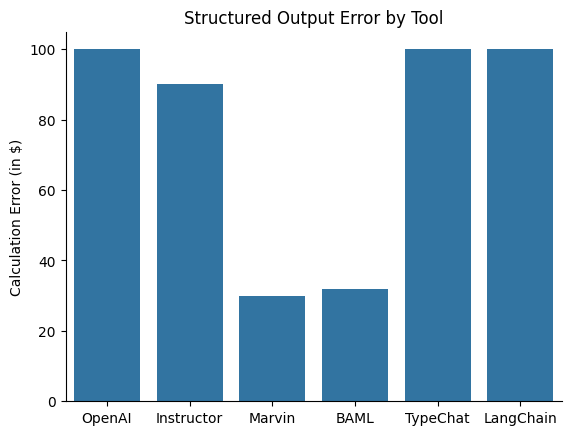

In [26]:
results = [structured_output_error, instructor_error, marvin_error, baml_error, typechat_error, langchain_error]
titles = ['OpenAI', 'Instructor', 'Marvin', 'BAML', 'TypeChat', 'LangChain']

sns.barplot(x=titles, y=results)

plt.title('Structured Output Error by Tool')
plt.ylabel('Calculation Error (in $)')

sns.despine()

plt.show()

### The Solution: Multi-Step Approach Using **💧 Instill VDP**

This problem is easily solved using an Instill VDP pipeline that separates reasoning and structuring tasks into a two-step process. It first generates an unstructured reasoning response which is then passed to a second component which is solely responsible for structuring the reasoning response into the desired data model. The final output is delivered as a JSON object.

Please view and explore the components and structure of the [`multistep-structured-output`](https://instill.tech/george_strong/pipelines/multistep-structured-output/playground) pipeline in the no-code editor window shown below. Note that you can expand the components in the pipeline by selecting the `+` icon.

In [27]:
IFrame('https://instill.tech/george_strong/pipelines/multistep-structured-output/preview', width=1000, height=800)

In [28]:
openai_multi_structured = client.pipeline_service.trigger_pipeline(
    'multistep-structured-output', [],
    [{"context": context,
      "question": question}])

openai_multi_structured_dict = MessageToDict(openai_multi_structured)['outputs'][0]['answer']
openai_multi_structured_dict

{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java'],
 'cost': 2215.0}

In [29]:
multi_structured_output_error = abs(openai_multi_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${multi_structured_output_error}')

Cost calculation error: $0.0


Despite using two LLM inferences involved in this multi-step pipeline, it is worth noting that the cost will likely still be less than many of the structuring output tools that have been considered, as these often rely on making repeat API calls with modified prompts until the output can be successfully parsed into the required data model.

### Benchmarking Structured Outputs

⚠️ **Warning** - This section involves running multiple API calls using your configured OpenAI and Instill AI API tokens. If you do not want to be charged for re-running this benchmark, please do not run this cell.

Here, we benchmark the performance of each output structuring method by running multiple inferences with each. We then visualize the distributions of errors with respect to true cost value ($2215), calculate performance metrics, and conduct statistical tests to determine if the observed deviations are statistically significant.

In [30]:
from functools import wraps

def handle_errors(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f'Error in {func.__name__}:', e)
            return None
    return wrapper

In [31]:
@handle_errors
def get_structured_output() -> float:
    openai_structured = client.pipeline_service.trigger_pipeline(
        'structured-output', [],
        [{"context": context,
          "question": question}])

    openai_structured_dict = MessageToDict(openai_structured)['outputs'][0]['answer']
    cost = openai_structured_dict['cost']
    print('   Structured Cost:', cost)
    return cost


@handle_errors
def get_multistep_structured_output() -> float:
    openai_multi_structured = client.pipeline_service.trigger_pipeline(
        'multistep-structured-output', [],
        [{"context": context,
          "question": question}])
    openai_multi_structured_dict = MessageToDict(openai_multi_structured)['outputs'][0]['answer']
    cost = openai_multi_structured_dict['cost']
    print('   Multi-Step Structured Cost:', cost)
    return cost


@handle_errors
def get_instructor_output() -> float:
    instructor_response = instructor_client.chat.completions.create(
        model="gpt-4o",
        response_model=DataModel,
        messages=[{"role": "user", "content": prompt}],
        temperature=1,
    )
    instructor_dict = instructor_response.model_dump()
    cost = instructor_dict['cost']
    print('   Instructor Cost:', cost)
    return cost


@handle_errors
def get_marvin_output() -> float:
    marvin_response = process(resume, question)
    marvin_dict = marvin_response.model_dump()
    cost = marvin_dict['cost']
    print('   Marvin Cost:', cost)
    return cost


@handle_errors
def get_baml_output() -> float:
    baml_response = b.ExtractResume(context)
    baml_dict = baml_response.model_dump()
    cost = baml_dict['cost']
    print('   BAML Cost:', cost)
    return cost


@handle_errors
def get_langchain_output() -> float:
    langchain_response = structured_llm.invoke(prompt)
    langchain_dict = langchain_response.dict()
    cost = langchain_dict['cost']
    print('   LangChain Cost:', cost)
    return cost

In [32]:
iterations = 50

structured_values = []
multistep_structured_values = []
instructor_values = []
marvin_values = []
baml_values = []
langchain_values = []

for iteration in range(iterations):
    print(f'Iteration {iteration+1} of {iterations}')
    structured_values.append(get_structured_output())
    multistep_structured_values.append(get_multistep_structured_output())
    instructor_values.append(get_instructor_output())
    marvin_values.append(get_marvin_output())
    baml_values.append(get_baml_output())
    langchain_values.append(get_langchain_output())

Iteration 1 of 50
   Structured Cost: 2235.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:19:50,039.039 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:19:51,822.822 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2265.0
   BAML Cost: 2204.5


2024-08-28 16:19:55,670.670 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2295.0
Iteration 2 of 50
   Structured Cost: 2350.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:20:09,187.187 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:20:10,418.418 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2225.0
   BAML Cost: 2305.0


2024-08-28 16:20:20,451.451 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 3 of 50
   Structured Cost: 2290.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:20:33,661.661 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2181.0


2024-08-28 16:20:34,883.883 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2146.0
   BAML Cost: 2220.0


2024-08-28 16:20:39,702.702 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2122.0
Iteration 4 of 50
   Structured Cost: 2155.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:20:52,606.606 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:20:53,737.737 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2085.0
   BAML Cost: 2047.0


2024-08-28 16:20:58,235.235 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2093.0
Iteration 5 of 50
   Structured Cost: 2285.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:21:09,295.295 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:21:11,140.140 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 1920.0
   BAML Cost: 2116.5


2024-08-28 16:21:19,229.229 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2209.0
Iteration 6 of 50
   Structured Cost: 2378.5
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:21:31,005.005 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2239.0


2024-08-28 16:21:32,048.048 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2021.0
   BAML Cost: 2226.5


2024-08-28 16:21:35,409.409 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2323.0
Iteration 7 of 50
   Structured Cost: 2375.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:21:47,184.184 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1955.0


2024-08-28 16:21:48,720.720 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2065.0
   BAML Cost: 2287.0


2024-08-28 16:21:54,455.455 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2026.0
Iteration 8 of 50
   Structured Cost: 2295.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:22:06,641.641 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2083.0


2024-08-28 16:22:07,973.973 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2116.5
   BAML Cost: 2355.0


2024-08-28 16:22:13,160.160 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2165.0
Iteration 9 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:22:24,017.017 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:22:25,074.074 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2197.0


2024-08-28 16:22:27,568.568 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2184.5
Iteration 10 of 50
   Structured Cost: 2225.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:22:38,080.080 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2146.0


2024-08-28 16:22:39,308.308 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2155.0


2024-08-28 16:22:44,388.388 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 11 of 50
   Structured Cost: 2255.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:22:57,092.092 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2065.0


2024-08-28 16:22:58,766.766 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2280.0


2024-08-28 16:23:01,530.530 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 12 of 50
   Structured Cost: 2215.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:23:15,470.470 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1935.0


2024-08-28 16:23:16,682.682 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2121.0
   BAML Cost: 2295.0


2024-08-28 16:23:19,754.754 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 1972.5
Iteration 13 of 50
   Structured Cost: 2215.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:23:30,788.788 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2030.0


2024-08-28 16:23:31,941.941 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2075.0
   BAML Cost: 2095.0


2024-08-28 16:23:36,547.547 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2225.0
Iteration 14 of 50
   Structured Cost: 2180.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:23:46,788.788 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:23:47,782.782 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2295.0
   BAML Cost: 2215.0


2024-08-28 16:23:51,602.602 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2156.5
Iteration 15 of 50
   Structured Cost: 2095.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:24:01,841.841 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2239.0


2024-08-28 16:24:03,275.275 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2125.0


2024-08-28 16:24:10,852.852 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2125.0
Iteration 16 of 50
   Structured Cost: 2255.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:24:21,355.355 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1985.0


2024-08-28 16:24:22,426.426 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2165.0


2024-08-28 16:24:28,363.363 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2225.0
Iteration 17 of 50
   Structured Cost: 2127.5
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:24:38,705.705 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2049.0


2024-08-28 16:24:39,936.936 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2185.0
   BAML Cost: 2120.0


2024-08-28 16:24:44,033.033 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2070.0
Iteration 18 of 50
   Structured Cost: 2230.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:25:02,668.668 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:25:03,692.692 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2199.0
   BAML Cost: 2239.0


2024-08-28 16:25:08,914.914 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2215.0
Iteration 19 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:25:21,201.201 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:25:22,534.534 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2325.0
   BAML Cost: 2065.0


2024-08-28 16:25:27,243.243 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2323.0
Iteration 20 of 50
   Structured Cost: 2235.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:25:36,663.663 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:25:39,122.122 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2192.0
   BAML Cost: 2155.0


2024-08-28 16:25:42,911.911 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2295.0
Iteration 21 of 50
   Structured Cost: 2165.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:25:55,405.405 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2131.0


2024-08-28 16:25:56,429.429 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2185.0
   BAML Cost: 2225.0


2024-08-28 16:26:00,933.933 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2210.0
Iteration 22 of 50
   Structured Cost: 2255.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:26:11,378.378 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:26:12,608.608 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2175.0
   BAML Cost: 2295.0


2024-08-28 16:26:16,287.287 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2104.5
Iteration 23 of 50
   Structured Cost: 2325.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:26:26,431.431 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:26:27,457.457 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2120.0
   BAML Cost: 2156.5


2024-08-28 16:26:30,117.117 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2201.5
Iteration 24 of 50
   Structured Cost: 2226.5
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:26:40,867.867 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2159.0


2024-08-28 16:26:42,304.304 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2035.0
   BAML Cost: 2236.5


2024-08-28 16:26:46,709.709 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2159.0
Iteration 25 of 50
   Structured Cost: 2395.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:26:57,514.514 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2146.0


2024-08-28 16:26:59,806.806 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2040.0
   BAML Cost: 2187.0


2024-08-28 16:27:03,194.194 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 26 of 50
   Structured Cost: 2265.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:27:14,353.353 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2035.0


2024-08-28 16:27:15,892.892 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2175.0
   BAML Cost: 2030.0


2024-08-28 16:27:20,147.147 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2315.0
Iteration 27 of 50
   Structured Cost: 2155.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:27:31,148.148 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2065.0


2024-08-28 16:27:33,094.094 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2135.0


2024-08-28 16:27:36,900.900 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 28 of 50
   Structured Cost: 1985.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:27:47,876.876 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2165.0


2024-08-28 16:27:49,581.581 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2325.0
   BAML Cost: 2102.0


2024-08-28 16:27:52,857.857 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2136.5
Iteration 29 of 50
   Structured Cost: 2284.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:28:04,428.428 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2070.0


2024-08-28 16:28:05,863.863 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2145.0
   BAML Cost: 2122.5


2024-08-28 16:28:10,062.062 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2040.0
Iteration 30 of 50
   Structured Cost: 2115.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:28:23,270.270 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2065.0


2024-08-28 16:28:24,604.604 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2119.0
   BAML Cost: 2176.0


2024-08-28 16:28:27,266.266 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 31 of 50
   Structured Cost: 2123.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:28:37,913.913 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:28:39,039.039 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2175.0


2024-08-28 16:28:43,751.751 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2257.5
Iteration 32 of 50
   Structured Cost: 2265.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:28:56,509.509 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2195.0


2024-08-28 16:28:57,721.721 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2171.0
   BAML Cost: 2095.0


2024-08-28 16:29:01,466.466 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2156.0
Iteration 33 of 50
   Structured Cost: 2305.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:29:13,651.651 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2125.0


2024-08-28 16:29:14,676.676 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2165.0
   BAML Cost: 2236.5


2024-08-28 16:29:17,381.381 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2111.0
Iteration 34 of 50
   Structured Cost: 2075.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:29:29,830.830 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2145.0


2024-08-28 16:29:31,369.369 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2061.0
   BAML Cost: 2189.5


2024-08-28 16:29:35,753.753 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2175.0
Iteration 35 of 50
   Structured Cost: 2235.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:29:50,311.311 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2175.0


2024-08-28 16:29:51,745.745 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2065.0
   BAML Cost: 2215.0


2024-08-28 16:29:57,352.352 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2195.0
Iteration 36 of 50
   Structured Cost: 2275.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:30:07,922.922 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:30:09,359.359 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2275.0
   BAML Cost: 2035.0


2024-08-28 16:30:13,658.658 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2125.0
Iteration 37 of 50
   Structured Cost: 2331.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:30:25,843.843 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2239.5


2024-08-28 16:30:27,074.074 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2121.0
   BAML Cost: 2120.5


2024-08-28 16:30:31,067.067 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 38 of 50
   Structured Cost: 2245.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:30:43,882.882 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2035.0


2024-08-28 16:30:45,096.096 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2265.0


2024-08-28 16:30:49,603.603 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 39 of 50
   Structured Cost: 2395.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:31:03,455.455 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:31:05,371.371 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2320.0
   BAML Cost: 2080.5


2024-08-28 16:31:11,210.210 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 40 of 50
   Structured Cost: 2195.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:31:22,021.021 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:31:23,749.749 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2297.0
   BAML Cost: 2120.0


2024-08-28 16:31:27,928.928 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2015.0
Iteration 41 of 50
   Structured Cost: 2415.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:31:38,755.755 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2065.0


2024-08-28 16:31:40,085.085 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2145.0


2024-08-28 16:31:45,162.162 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2155.0
Iteration 42 of 50
   Structured Cost: 2380.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:31:55,957.957 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:31:57,287.287 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2135.0
   BAML Cost: 2195.0


2024-08-28 16:32:05,581.581 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 1994.0
Iteration 43 of 50
   Structured Cost: 2115.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:32:16,241.241 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:32:17,357.357 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2259.0
   BAML Cost: 2065.0


2024-08-28 16:32:22,865.865 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2201.0
Iteration 44 of 50
   Structured Cost: 2395.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:32:36,815.815 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 16:32:38,659.659 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2205.0
   BAML Cost: 2171.0


2024-08-28 16:32:46,133.133 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2380.0
Iteration 45 of 50
   Structured Cost: 2185.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:32:56,886.886 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2023.0


2024-08-28 16:32:58,318.318 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2136.0
   BAML Cost: 2065.0


2024-08-28 16:33:05,092.092 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2095.0
Iteration 46 of 50
   Structured Cost: 2625.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:33:16,443.443 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2095.0


2024-08-28 16:33:17,968.968 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2361.0


2024-08-28 16:33:22,998.998 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2162.5
Iteration 47 of 50
   Structured Cost: 2325.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:33:32,623.623 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 16:33:34,135.135 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2045.0
   BAML Cost: 2315.0


2024-08-28 16:33:39,383.383 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2201.0
Iteration 48 of 50
   Structured Cost: 2425.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:33:52,590.590 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2165.0


2024-08-28 16:33:54,794.794 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2201.5
   BAML Cost: 2365.0


2024-08-28 16:33:59,657.657 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2021.5
Iteration 49 of 50
   Structured Cost: 2225.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:34:10,308.308 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1965.0


2024-08-28 16:34:12,191.191 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2335.0
   BAML Cost: 2201.0


2024-08-28 16:34:15,048.048 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 50 of 50
   Structured Cost: 2365.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 16:34:25,461.461 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2099.0


2024-08-28 16:34:27,247.247 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2171.0
   BAML Cost: 2225.0


2024-08-28 16:34:32,129.129 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2209.0


In [42]:
data = {
    'Multistep Instill VDP': multistep_structured_values,
    'OpenAI Structured API': structured_values,
    'Instructor': instructor_values,
    'Marvin': marvin_values,
    'BAML': baml_values,
    'LangChain': langchain_values,
    'TypeChat': [typechat_dict['cost']]*iterations
}

df = pd.DataFrame(data) - true_answer

In [43]:
df.describe()

,Multistep Instill VDP,OpenAI Structured API,Instructor,Marvin,BAML,LangChain,TypeChat
count,50.0,50.000000,50.000000,50.00000,50.000000,50.000000,50.0
mean,0.0,48.110000,-106.310000,-43.74000,-31.540000,-53.350000,-100.0
std,0.0,111.254273,66.437241,90.31556,86.382505,88.672652,0.0
min,0.0,-230.000000,-280.000000,-295.00000,-185.000000,-242.500000,-100.0
25%,0.0,-15.000000,-148.750000,-97.87500,-94.875000,-100.000000,-100.0
50%,0.0,40.000000,-100.000000,-40.00000,-33.500000,-58.750000,-100.0
75%,0.0,126.500000,-80.000000,20.50000,19.000000,-5.250000,-100.0
max,0.0,410.000000,24.500000,120.00000,150.000000,165.000000,-100.0


### Visualise with a Box Plot

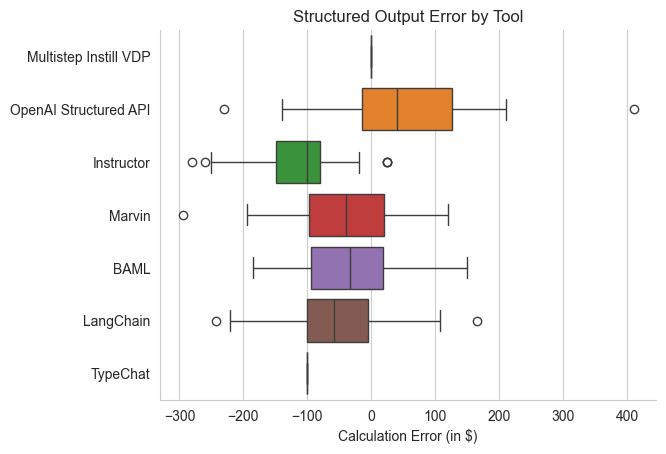

In [44]:
sns.set_style('whitegrid')
sns.boxplot(data=df, orient='y', fill=True)
plt.title('Structured Output Error by Tool')
sns.despine()
plt.xlabel('Calculation Error (in $)')
plt.show()

### Mean Absolute Error

In [45]:
df.abs().mean()

Multistep Instill VDP      0.00
OpenAI Structured API     93.09
Instructor               109.21
Marvin                    78.42
BAML                      74.60
LangChain                 83.41
TypeChat                 100.00
dtype: float64

### Statistical Significance

In [46]:
!pip install scipy --quiet
from scipy import stats

In [47]:
p_values = {}

for column in df.columns:
    _, p_value = stats.ttest_1samp(df[column], 0)
    p_values[column] = p_value

for column, p_value in p_values.items():
    print(f"Column: {column} - p-value: {p_value:.4f}")

Column: Multistep Instill VDP - p-value: nan
Column: OpenAI Structured API - p-value: 0.0036
Column: Instructor - p-value: 0.0000
Column: Marvin - p-value: 0.0013
Column: BAML - p-value: 0.0129
Column: LangChain - p-value: 0.0001
Column: TypeChat - p-value: 0.0000


/opt/miniconda3/envs/instill/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
